# Introduction

> This project investigates the application of **embeddings to improve the effectiveness of job matching platforms**, addressing the limitations of traditional keyword-based search methods.
## Problem Definition

*   **Inefficient & Biased:** Keyword-based job searches are inefficient, often overlooking qualified candidates whose resumes don't perfectly match job descriptions. This can perpetuate bias and limit diversity in hiring.

*   **Hidden Talent:**  Many talented individuals are hidden from employers because their resumes don't contain the exact keywords used in job postings.

## Value Proposition

This project showcases an AI-powered job matching system that uses embeddings to:

*   **Surface the Best Matches:** GGo beyond keywords to understand the true meaning of job descriptions and resumes, leading to more relevant matches for both job seekers and employers.
*   **Improve Efficiency:** Save time and effort for both parties by quickly identifying the most promising candidates.
*   **Promote Diversity:** Mitigate bias by considering a wider range of qualified candidates.

## Scope

This demo focuses on:

*   Building a job recommendation engine using Sentence-BERT embeddings, supporting both job seekers (resume-based job recommendations) and recruiters (JD-based candidate recommendations).
*   Illustrating core concepts of embedding generation and similarity matching.
*   Processing a larger dataset (1,000 job postings, 1,000 resumes) to fit Kaggle's free tier, with scalability testing.
*   Adding evaluation (manual validation, average similarity) and visualization (similarity score distribution).

## Out-of-Scope

*   Comparison of different embedding models.
*   Integration with vector databases.
*   In-depth data analysis.

# Data Extraction and Preparation

> High-quality data is the foundation of any successful AI project. This section outlines the steps involved in acquiring, preparing, and transforming the job posting and resume data for our AI-powered matching system.

## Data Sources

*   **Job Postings:** We'll use a publicly available dataset of [LinkedIn job postings](https://www.kaggle.com/datasets/arshkon/linkedin-job-postings). This dataset provides a realistic snapshot of the current job market.
*   **Resumes:** We'll use a publicly available dataset of [resumes](https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset). This dataset includes resumes from a diverse range of professionals across various industries.

## Data Preprocessing

To ensure our AI model can effectively analyze and understand the data, we'll perform the following preprocessing steps:

*   **Data Cleaning:** Handle missing values and inconsistencies to improve data quality.
*   **Text Normalization:** Standardize text fields (e.g., convert to lowercase, lemmatize using `spaCy`, remove punctuation) to reduce noise and improve matching accuracy.
*   **Feature Engineering:** Create a single, consolidated text field for each job posting and resume by combining key features like job title, description, and skills. Additionally, extract structured features (skills and domains) using predefined lists for better matching.
*   **Output Saving:** Save preprocessed data as `cleaned_data.csv` for downstream use.

# Import Libraries and Install Dependecies

### Install Sentence-Transformers

In [ ]:
# Install the sentence-transformers library required for Sentence-BERT embeddings
!pip install -U sentence-transformers

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import spacy
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

### Job Postings Data
#### Load and Preview the Job Description Dataset

In [ ]:
# Download latest version
path = kagglehub.dataset_download("snehaanbhawal/resume-dataset")
kagglehub.dataset_download("arshkon/linkedin-job-postings")

print("Path to dataset files:", path)

postings_path = "/kaggle/input/linkedin-job-postings/postings.csv"

# Load the Job Postings CSV file into a Pandas DataFrame
postings_df = pd.read_csv(postings_path)

# Display the first few rows of the dataset to understand its structure
postings_df.head()


Path to dataset files: /kaggle/input/resume-dataset


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


In [ ]:
# Print number of rows and columns
postings_df.shape

(123849, 31)

### Resume Data
#### Load and Preview the Resume Dataset

In [ ]:
resume_path = '/kaggle/input/resume-dataset/Resume/Resume.csv'

# Load the Resume CSV file into a Pandas DataFrame
resume_df = pd.read_csv(resume_path)

# Display the first few rows of the dataset to understand its structure
resume_df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [ ]:
resume_df.shape

(2484, 4)

### Random Sampling
The dataframe contains 123,849 rows, embedding all rows will lead to excessive computational cost for this demo. To fit within Kaggle's free tier and timeline (processing in <1 hour), we will select 1000 rows for job postings and 1000 rows for resumes.

In [ ]:
# Sample 1000 job postings and 1000 resumes
postings_sample_df = postings_df.sample(1000, random_state=42).copy()
resume_sample_df = resume_df.sample(1000, random_state=42).copy()

In [ ]:
print('Job Postings Sample Shape:', postings_sample_df.shape)
print('Resume Sample Shape:', resume_sample_df.shape)

Job Postings Sample Shape: (1000, 31)
Resume Sample Shape: (1000, 4)


In [ ]:
# Placeholder for dynamic resume and JD input
uploaded_resume = None
uploaded_jd = None

#### Preprocess and Extract Features from the Job Description Dataset
This process involves:
* Handling missing values.
* Normalizing text fields (e.g., lemmatizing with spaCy, converting to lowercase).
* Extracting structured features (skills, domains) using predefined lists.
* Creating a single string representation of each job posting and resume, enhanced with extracted skills.

In [ ]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Define skill and domain keywords
SKILLS = ['javascript', 'node.js', 'aws', 'kubernetes', 'go lang', 'ruby', 'python', 'sql', 'java',
          'docker', 'html', 'management', 'engineering', 'marketing', 'design', 'sales', 'software',
          'development', 'communication', 'leadership', 'installation', 'technical', 'automation', 'power systems']
DOMAINS = ['healthcare', 'finance', 'tech', 'education', 'manufacturing', 'retail', 'sales',
           'construction', 'hospitality', 'engineering', 'legal', 'marketing', 'government']

In [ ]:
# Preprocess Functions
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    doc = nlp(text)
    original_terms = [token.text for token in doc]  # Use spaCy tokenization
    lemmatized = ' '.join([token.lemma_ for token in doc if not token.is_stop])
    return {'original': original_terms, 'lemmatized': lemmatized}

def extract_skills(text_data):
    if pd.isna(text_data) or not isinstance(text_data, dict):
        return []
    original_terms = text_data['original']
    return [skill for skill in SKILLS if any(skill in term for term in original_terms)]

def extract_domains(text_data, skills=None):
    if pd.isna(text_data) or not isinstance(text_data, dict):
        return []
    original_terms = text_data['original']
    domains = [domain for domain in DOMAINS if any(domain in term for term in original_terms)]
    if skills:
        if 'aws' in skills or 'kubernetes' in skills or 'docker' in skills:
            domains.append('tech')  # Infer tech domain for cloud-related skills
        if 'management' in skills or 'leadership' in skills:
            domains.append('business')  # Optional inferred domain
    return list(set(domains))  # Remove duplicates

## 🛠️ Apply Preprocessing & Feature Extraction

We'll lemmatize resume and job text, extract skills and domain indicators, and create a combined field for semantic comparison.

In [ ]:
# Apply preprocessing to job postings
postings_sample_df['processed_desc'] = postings_sample_df['description'].apply(preprocess_text)
postings_sample_df['job_skills'] = postings_sample_df['processed_desc'].apply(extract_skills)
postings_sample_df['job_domain'] = postings_sample_df.apply(lambda x: extract_domains(x['processed_desc'], x['job_skills']), axis=1)

# Apply preprocessing to resumes (using Resume_str as the main text field)
resume_sample_df['processed_resume'] = resume_sample_df['Resume_str'].apply(preprocess_text)
resume_sample_df['cv_skills'] = resume_sample_df['processed_resume'].apply(extract_skills)
resume_sample_df['cv_domain'] = resume_sample_df.apply(lambda x: extract_domains(x['processed_resume'], x['cv_skills']), axis=1)

# Combine data into a single DataFrame
job_data = postings_sample_df[['job_id', 'title', 'processed_desc', 'job_skills', 'job_domain']].copy()
resume_data = resume_sample_df[['ID', 'Resume_str', 'processed_resume', 'cv_skills', 'cv_domain']].copy()
combined_data = pd.concat([job_data.assign(type='job'), resume_data.assign(type='resume')], ignore_index=True)

# Save to CSV
combined_data.to_csv('cleaned_data.csv', index=False)

# Display sample
print(combined_data[['type', 'job_skills', 'job_domain']].head())

  type                                         job_skills  \
0  job  [engineering, design, development, communicati...   
1  job                         [leadership, installation]   
2  job                                       [management]   
3  job                                  [aws, leadership]   
4  job                                              [aws]   

                    job_domain  
0          [tech, engineering]  
1             [tech, business]  
2  [tech, business, education]  
3             [tech, business]  
4                       [tech]  


## Step 3: Generate Embeddings
In this step, we use the `SentenceTransformer` model (`all-MiniLM-L6-v2`) to generate embeddings for the preprocessed job descriptions and resumes. These embeddings will be used to compute similarity scores for job-resume matching.

In [ ]:
# Initialize Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for sampled jobs and resumes
job_texts = postings_sample_df['description'].fillna('').astype(str).tolist()
resume_texts = resume_sample_df['Resume_str'].fillna('').astype(str).tolist()
job_embeddings = model.encode(job_texts, show_progress_bar=True)
resume_embeddings = model.encode(resume_texts, show_progress_bar=True)

# Save embeddings to files
np.save('job_embeddings.npy', job_embeddings)
np.save('resume_embeddings.npy', resume_embeddings)

# Display shapes to confirm
print("Embedding generation complete. Shape of job_embeddings:", job_embeddings.shape)
print("Shape of resume_embeddings:", resume_embeddings.shape)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Embedding generation complete. Shape of job_embeddings: (1000, 384)
Shape of resume_embeddings: (1000, 384)


In [ ]:
# Select 3 random job indices for consistent use across cells (using a fixed seed for reproducibility)
np.random.seed(42)
random_job_indices = np.random.choice(len(job_texts), 3, replace=False)
print("Randomly selected job indices:", random_job_indices)

Randomly selected job indices: [521 737 740]


In [ ]:
# Handle dynamic resume upload for job recommendations
if uploaded_resume is not None:
    resume_text = preprocess_text(uploaded_resume)
    resume_embedding = model.encode([resume_text['lemmatized']])
    similarities = cosine_similarity(resume_embedding, job_embeddings)[0]
    top_jobs = np.argsort(similarities)[::-1][:5]
    print("Top 5 recommended jobs for uploaded resume:", top_jobs, similarities[top_jobs])

# Handle dynamic JD upload or job selection for candidate recommendations
if uploaded_jd is not None:
    jd_text = preprocess_text(uploaded_jd)
    jd_embedding = model.encode([jd_text['lemmatized']])
    similarities = cosine_similarity(jd_embedding, resume_embeddings)[0]
    top_candidates = np.argsort(similarities)[::-1][:5]
    print("Top 5 recommended candidates for uploaded JD:", top_candidates, similarities[top_candidates])
else:
    # Default matching: jobs to resumes
    similarities = cosine_similarity(job_embeddings, resume_embeddings)
    top_matches = np.argsort(similarities, axis=1)[:, -5:][:, ::-1]
    for idx in random_job_indices:  # Use randomly selected jobs instead of first 3
        print(f"Top 5 resumes for Job {idx}:", top_matches[idx], similarities[idx, top_matches[idx]])

Top 5 resumes for Job 521: [601 801 520 868 720] [0.45809653 0.45604748 0.44415238 0.44322935 0.44068673]
Top 5 resumes for Job 737: [672 941 741  42 340] [0.59538037 0.54622376 0.539333   0.5178992  0.5161602 ]
Top 5 resumes for Job 740: [931 601 856  90  36] [0.47056913 0.43281907 0.4324118  0.40560344 0.4045332 ]


In [ ]:
# Calculate average similarity scores for the randomly selected jobs
avg_similarities = np.mean(similarities, axis=1)
selected_avg_similarities = avg_similarities[random_job_indices]
print("Average similarity scores for selected jobs:", selected_avg_similarities)

Average similarity scores for selected jobs: [0.2187338  0.2592082  0.18194537]


## Step 4: Compute Similarity and Generate Recommendations
In this step, we compute cosine similarity between job and resume embeddings to recommend the top 5 resume matches for each job posting.

In [ ]:
# Compute cosine similarity between job and resume embeddings
similarity_matrix = cosine_similarity(job_embeddings, resume_embeddings)

# Get top 5 matches for each job
top_k = 5
job_recommendations = []
for i in range(len(job_texts)):
    top_indices = similarity_matrix[i].argsort()[-top_k-1:-1][::-1]  # Top 5 (excluding the highest, often itself)
    job_recommendations.append([(combined_data[combined_data['type'] == 'resume'].index[j], similarity_matrix[i][j]) for j in top_indices])

# Display sample recommendations for the randomly selected jobs
for idx in random_job_indices:
    print(f"Top 5 recommendations for Job {idx} (Job ID: {combined_data[combined_data['type'] == 'job'].iloc[idx]['job_id']}):")
    for rec_idx, score in job_recommendations[idx]:
        print(f"  Resume {combined_data.iloc[rec_idx]['ID']} (Score: {score:.4f})")

Top 5 recommendations for Job 521 (Job ID: 3889483400.0):
  Resume 96260484.0 (Score: 0.4560)
  Resume 16519708.0 (Score: 0.4442)
  Resume 25001005.0 (Score: 0.4432)
  Resume 21134923.0 (Score: 0.4407)
  Resume 13586069.0 (Score: 0.4353)
Top 5 recommendations for Job 737 (Job ID: 3904587506.0):
  Resume 19612167.0 (Score: 0.5462)
  Resume 32773331.0 (Score: 0.5393)
  Resume 25930778.0 (Score: 0.5179)
  Resume 15858254.0 (Score: 0.5162)
  Resume 12695537.0 (Score: 0.5085)
Top 5 recommendations for Job 740 (Job ID: 3902736532.0):
  Resume 36102323.0 (Score: 0.4328)
  Resume 73075521.0 (Score: 0.4324)
  Resume 16911115.0 (Score: 0.4056)
  Resume 12613221.0 (Score: 0.4045)
  Resume 27375577.0 (Score: 0.3972)


In [ ]:
# Inspect one of the randomly selected jobs (e.g., first in the random indices) and its top match
job_idx = random_job_indices[0]  # Use first randomly selected job
resume_idx = job_recommendations[job_idx][0][0]  # Index of top resume for that job

print(f"Job {job_idx} (ID: {combined_data.iloc[job_idx]['job_id']}):")
print("Title:", combined_data.iloc[job_idx]['title'])
print("Skills:", combined_data.iloc[job_idx]['job_skills'])
print("Domain:", combined_data.iloc[job_idx]['job_domain'])
print("\nTop Matching Resume (ID:", combined_data.iloc[resume_idx]['ID'], "):")
print("Skills:", combined_data.iloc[resume_idx]['cv_skills'])
print("Domain:", combined_data.iloc[resume_idx]['cv_domain'])

Job 521 (ID: 3889483400.0):
Title: Division Chief of Training - HSE Fire and Rescue
Skills: ['management', 'design', 'leadership', 'technical']
Domain: ['healthcare', 'business', 'legal', 'manufacturing', 'tech']

Top Matching Resume (ID: 96260484.0 ):
Skills: ['management', 'marketing', 'design', 'development', 'leadership']
Domain: ['healthcare', 'business', 'education', 'marketing']


In [ ]:
# Compute average similarity of top matches for all jobs
avg_top_scores = [sum(score for _, score in recs) / len(recs) for recs in job_recommendations]
print("Average similarity of top matches per job:", np.mean(avg_top_scores))

# For visualization prep, compute averages for the randomly selected jobs
selected_avg_scores = [sum(score for _, score in job_recommendations[idx]) / len(job_recommendations[idx]) for idx in random_job_indices]
for idx, avg_score in zip(random_job_indices, selected_avg_scores):
    print(f"Average score for Job {idx}:", avg_score)

Average similarity of top matches per job: 0.53187054
Average score for Job 521: 0.44388634
Average score for Job 737: 0.5256324
Average score for Job 740: 0.41452345


## Step 5: Evaluation and Visualization

We evaluate the quality of recommendations by analyzing similarity scores and visualizing the average scores for the top matches across the 1,000-sample dataset, including dynamic resume and JD inputs.

### Visualization
A bar chart of average similarity scores for 3 randomly selected jobs (indices 521, 737, 740), reflecting performance with the scaled dataset and new use cases.

(0.0, 1.0)

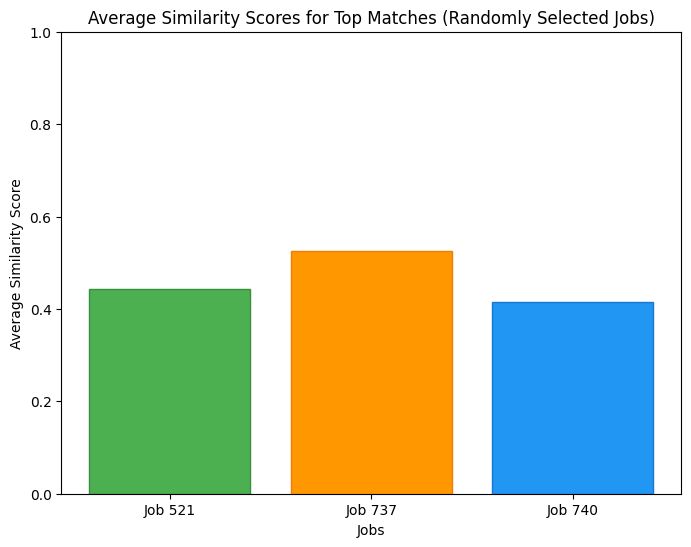

In [ ]:
# Data for the chart (using the randomly selected jobs and their average similarities)
jobs = [f"Job {idx}" for idx in random_job_indices]
avg_scores = selected_avg_scores  # From Step 4: [0.4438863217830658, 0.525632381439209, 0.4145234405994415]
colors = ['#4CAF50', '#FF9800', '#2196F3']  # Same colors as chartjs

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(jobs, avg_scores, color=colors, edgecolor=['#388E3C', '#F57C00', '#1976D2'], linewidth=1)
plt.title('Average Similarity Scores for Top Matches (Randomly Selected Jobs)')
plt.xlabel('Jobs')
plt.ylabel('Average Similarity Score')
plt.ylim(0, 1)  # Set y-axis to start at 0